## Introduction to solving Poisson and time-dependent equations using the finite element method

Required software:
- paraview
- an scp file transfer protocol (if windows)

### First example:

Solving $$ \nabla^2 v = f(x),$$ subject to $$\nabla v = 4$$ and $$f(x) = A e^{g(x)}$$

Below we write the fenics code to solve this example 

In [4]:

from dolfin import *
mesh = UnitIntervalMesh(5)
#mesh = UnitSquareMesh(5,5)
V = FunctionSpace(mesh,"CG",1)

def right(x,on_boundary):
  return x> 1- DOLFIN_EPS
#  return x[0]> 1- DOLFIN_EPS

g = Constant(0)
bc = DirichletBC(V,g,right)

#  Define the RHS 
f = Expression("A*exp(-pow(x[0]-0.5,2)/(2*pow(sigma,2)))",
 A=40, sigma=0.1, element=V.ufl_element())

u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(v),grad(u))*dx
L = f*v*dx - 4*v*ds

x = Function(V) 
solve(a == L, x, bc)

#plot(x)
#interactive()
File("soln.pvd")<< x


Need to transfer soln.pvd locally in order to view the result in paraview (via scp)


### Min/max problem

Solving $$ \nabla^2 v = 0 $$, subject to $$v(0) = 4$$ and $$v(1) = 0$$

In [5]:

from dolfin import *
mesh = UnitIntervalMesh(5)
V = FunctionSpace(mesh,"CG",1)

def left(x,on_boundary):
  return x<  DOLFIN_EPS

def right(x,on_boundary):
  return x> 1- DOLFIN_EPS

g = Constant(4)
bcL = DirichletBC(V,g,left)
g = Constant(0)
bcR = DirichletBC(V,g,right)
bcs = [bcL,bcR]

u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(v),grad(u))*dx
L = Constant(0.)*v*dx 

x = Function(V) 
solve(a == L, x, bcs)

plot(x)
interactive()


DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


### Time dependent problem

In [2]:
from dolfin import *
import numpy as np 


eps = 1e-2 
# Define Dirichlet boundary (x = 0 or x = 1)
class daBoundary(SubDomain):
  def inside(self,x,on_boundary):
    #if on_boundary:
    #  print x      
    return on_boundary

# Nonlinear equation 
class MyEquation(NonlinearProblem):
    def __init__(self, a, L):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
    def F(self, b, x):
        assemble(self.L, tensor=b)
    def J(self, A, x):
        assemble(self.a, tensor=A)

# time [ms]
# D [um^2/ms]
ts = [] # t [ms]
concs = [] # concentrations in [uM]  
if 1: 
  dt=0.1 # [ms] 
  T = 40 # [ms]
  D = Constant(5.0) # [um^2/ms]
          
  ## params 
  import numpy as np
  j= 0.1 # [uM/ms] 
  t = 0.0
  initConc = 1. # [uM] 
  
  mesh = UnitSquareMesh(2,2) 
  mesh.coordinates()[:] = mesh.coordinates()[:]*10
  boundaries = MeshFunction("size_t", mesh, 1) 
  outer = daBoundary()
  marker = 1      
  outer.mark(boundaries,marker)

  dx = Measure("dx",domain=mesh)
  ds = Measure("ds",subdomain_data=boundaries,domain=mesh)
  vol = assemble(Constant(1.)*dx)
  area = assemble(Constant(1.)*ds(marker))
  print "Vol ", vol, " Area ", area
  
  ## Define boundary condition 
  #u0 = Constant(1.0)
  #bcs=[]
  #bcs.append(DirichletBC(V, u0, subdomains,marker))
  V = FunctionSpace(mesh,"CG",1)
  
  # Define trial and test functions
  du    = TrialFunction(V)
  q  = TestFunction(V)
  # Define functions
  u   = Function(V)  # current solution
  u0  = Function(V)  # solution from previous converged step

  ## Attributes
  vol = assemble(Constant(1.)*dx(domain=mesh))
  area= assemble(Constant(1.)*ds(domain=mesh))
  boundaryArea= assemble(Constant(1.)*ds(marker,domain=mesh))
  #print "A,bA, V ", area, boundaryArea,vol

  ## Init Cond 
  ic = Constant(initConc)
  u.interpolate(ic) 
  u0.interpolate(ic)


  # store data 
  File("test.pvd") << u
  
  ## RHS weak form 
  # Diffusion
  RHS = -inner(D*grad(u), grad(q))*dx
  # fluxes
  RHS += j*(vol/boundaryArea)*q*ds(marker)

  ## LHS 
  # from u1 = u0 + du/dt*del_t ==> (u1-u0) - du/dt * dt = 0 
  L = (u-u0)*q*dx - dt * RHS

  
  # Compute directional derivative about u in the direction of du (Jacobian)
  a = derivative(L, u, du)  
  problem = MyEquation(a,L)
  solver = NewtonSolver()#"gmres")         

  ## Main loops 
  i=0     
  while (t < T):
      t += dt
      u0.vector()[:] = u.vector()
      solver.solve(problem, u.vector())


      r = u.vector()
      #print "Assemble %d/%f" % (i,assemble(u*dx)) # mesh=mesh)
      conci = assemble(u*dx)/vol
      if 1: 
        print "Conc[%d]: %f, t=%f" % (i,t,conci)
         
      # update 
      concs.append(conci)  
      ts.append(t)        
      i+=1

      plot(u)
interactive()

concs = np.array(concs)
ts = np.array(ts)

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


Vol  100.0  Area  40.0
Conc[0]: 0.100000, t=1.010000
Conc[1]: 0.200000, t=1.020000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[2]: 0.300000, t=1.030000
Conc[3]: 0.400000, t=1.040000
Conc[4]: 0.500000, t=1.050000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[5]: 0.600000, t=1.060000
Conc[6]: 0.700000, t=1.070000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[7]: 0.800000, t=1.080000
Conc[8]: 0.900000, t=1.090000
Conc[9]: 1.000000, t=1.100000
Conc[10]: 1.100000, t=1.110000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[11]: 1.200000, t=1.120000
Conc[12]: 1.300000, t=1.130000
Conc[13]: 1.400000, t=1.140000
Conc[14]: 1.500000, t=1.150000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[15]: 1.600000, t=1.160000
Conc[16]: 1.700000, t=1.170000
Conc[17]: 1.800000, t=1.180000
Conc[18]: 1.900000, t=1.190000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[19]: 2.000000, t=1.200000
Conc[20]: 2.100000, t=1.210000
Conc[21]: 2.200000, t=1.220000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[22]: 2.300000, t=1.230000
Conc[23]: 2.400000, t=1.240000
Conc[24]: 2.500000, t=1.250000
Conc[25]: 2.600000, t=1.260000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[26]: 2.700000, t=1.270000
Conc[27]: 2.800000, t=1.280000
Conc[28]: 2.900000, t=1.290000
Conc[29]: 3.000000, t=1.300000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[30]: 3.100000, t=1.310000
Conc[31]: 3.200000, t=1.320000
Conc[32]: 3.300000, t=1.330000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[33]: 3.400000, t=1.340000
Conc[34]: 3.500000, t=1.350000
Conc[35]: 3.600000, t=1.360000
Conc[36]: 3.700000, t=1.370000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[37]: 3.800000, t=1.380000
Conc[38]: 3.900000, t=1.390000
Conc[39]: 4.000000, t=1.400000
Conc[40]: 4.100000, t=1.410000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[41]: 4.200000, t=1.420000
Conc[42]: 4.300000, t=1.430000
Conc[43]: 4.400000, t=1.440000
Conc[44]: 4.500000, t=1.450000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[45]: 4.600000, t=1.460000
Conc[46]: 4.700000, t=1.470000
Conc[47]: 4.800000, t=1.480000
Conc[48]: 4.900000, t=1.490000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[49]: 5.000000, t=1.500000
Conc[50]: 5.100000, t=1.510000
Conc[51]: 5.200000, t=1.520000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[52]: 5.300000, t=1.530000
Conc[53]: 5.400000, t=1.540000
Conc[54]: 5.500000, t=1.550000
Conc[55]: 5.600000, t=1.560000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[56]: 5.700000, t=1.570000
Conc[57]: 5.800000, t=1.580000
Conc[58]: 5.900000, t=1.590000
Conc[59]: 6.000000, t=1.600000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[60]: 6.100000, t=1.610000
Conc[61]: 6.200000, t=1.620000
Conc[62]: 6.300000, t=1.630000


DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.


Conc[63]: 6.400000, t=1.640000
Conc[64]: 6.500000, t=1.650000
Conc[65]: 6.600000, t=1.660000
Conc[66]: 6.700000, t=1.670000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[67]: 6.800000, t=1.680000
Conc[68]: 6.900000, t=1.690000
Conc[69]: 7.000000, t=1.700000
Conc[70]: 7.100000, t=1.710000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[71]: 7.200000, t=1.720000
Conc[72]: 7.300000, t=1.730000
Conc[73]: 7.400000, t=1.740000
Conc[74]: 7.500000, t=1.750000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[75]: 7.600000, t=1.760000
Conc[76]: 7.700000, t=1.770000
Conc[77]: 7.800000, t=1.780000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[78]: 7.900000, t=1.790000
Conc[79]: 8.000000, t=1.800000
Conc[80]: 8.100000, t=1.810000
Conc[81]: 8.200000, t=1.820000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[82]: 8.300000, t=1.830000
Conc[83]: 8.400000, t=1.840000
Conc[84]: 8.500000, t=1.850000
Conc[85]: 8.600000, t=1.860000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[86]: 8.700000, t=1.870000
Conc[87]: 8.800000, t=1.880000
Conc[88]: 8.900000, t=1.890000
Conc[89]: 9.000000, t=1.900000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[90]: 9.100000, t=1.910000
Conc[91]: 9.200000, t=1.920000
Conc[92]: 9.300000, t=1.930000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[93]: 9.400000, t=1.940000
Conc[94]: 9.500000, t=1.950000
Conc[95]: 9.600000, t=1.960000
Conc[96]: 9.700000, t=1.970000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[97]: 9.800000, t=1.980000
Conc[98]: 9.900000, t=1.990000
Conc[99]: 10.000000, t=2.000000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[100]: 10.100000, t=2.010000
Conc[101]: 10.200000, t=2.020000
Conc[102]: 10.300000, t=2.030000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[103]: 10.400000, t=2.040000
Conc[104]: 10.500000, t=2.050000
Conc[105]: 10.600000, t=2.060000
Conc[106]: 10.700000, t=2.070000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[107]: 10.800000, t=2.080000
Conc[108]: 10.900000, t=2.090000
Conc[109]: 11.000000, t=2.100000
Conc[110]: 11.100000, t=2.110000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[111]: 11.200000, t=2.120000
Conc[112]: 11.300000, t=2.130000
Conc[113]: 11.400000, t=2.140000
Conc[114]: 11.500000, t=2.150000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[115]: 11.600000, t=2.160000
Conc[116]: 11.700000, t=2.170000
Conc[117]: 11.800000, t=2.180000
Conc[118]: 11.900000, t=2.190000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[119]: 12.000000, t=2.200000
Conc[120]: 12.100000, t=2.210000
Conc[121]: 12.200000, t=2.220000
Conc[122]: 12.300000, t=2.230000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[123]: 12.400000, t=2.240000
Conc[124]: 12.500000, t=2.250000
Conc[125]: 12.600000, t=2.260000
Conc[126]: 12.700000, t=2.270000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[127]: 12.800000, t=2.280000
Conc[128]: 12.900000, t=2.290000
Conc[129]: 13.000000, t=2.300000
Conc[130]: 13.100000, t=2.310000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[131]: 13.200000, t=2.320000
Conc[132]: 13.300000, t=2.330000
Conc[133]: 13.400000, t=2.340000
Conc[134]: 13.500000, t=2.350000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[135]: 13.600000, t=2.360000
Conc[136]: 13.700000, t=2.370000
Conc[137]: 13.800000, t=2.380000
Conc[138]: 13.900000, t=2.390000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[139]: 14.000000, t=2.400000
Conc[140]: 14.100000, t=2.410000
Conc[141]: 14.200000, t=2.420000
Conc[142]: 14.300000, t=2.430000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[143]: 14.400000, t=2.440000
Conc[144]: 14.500000, t=2.450000
Conc[145]: 14.600000, t=2.460000
Conc[146]: 14.700000, t=2.470000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[147]: 14.800000, t=2.480000
Conc[148]: 14.900000, t=2.490000
Conc[149]: 15.000000, t=2.500000
Conc[150]: 15.100000, t=2.510000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[151]: 15.200000, t=2.520000
Conc[152]: 15.300000, t=2.530000
Conc[153]: 15.400000, t=2.540000
Conc[154]: 15.500000, t=2.550000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[155]: 15.600000, t=2.560000
Conc[156]: 15.700000, t=2.570000
Conc[157]: 15.800000, t=2.580000
Conc[158]: 15.900000, t=2.590000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[159]: 16.000000, t=2.600000
Conc[160]: 16.100000, t=2.610000
Conc[161]: 16.200000, t=2.620000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[162]: 16.300000, t=2.630000
Conc[163]: 16.400000, t=2.640000
Conc[164]: 16.500000, t=2.650000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[165]: 16.600000, t=2.660000
Conc[166]: 16.700000, t=2.670000
Conc[167]: 16.800000, t=2.680000
Conc[168]: 16.900000, t=2.690000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[169]: 17.000000, t=2.700000
Conc[170]: 17.100000, t=2.710000
Conc[171]: 17.200000, t=2.720000
Conc[172]: 17.300000, t=2.730000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[173]: 17.400000, t=2.740000
Conc[174]: 17.500000, t=2.750000
Conc[175]: 17.600000, t=2.760000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[176]: 17.700000, t=2.770000
Conc[177]: 17.800000, t=2.780000
Conc[178]: 17.900000, t=2.790000
Conc[179]: 18.000000, t=2.800000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[180]: 18.100000, t=2.810000
Conc[181]: 18.200000, t=2.820000
Conc[182]: 18.300000, t=2.830000
Conc[183]: 18.400000, t=2.840000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[184]: 18.500000, t=2.850000
Conc[185]: 18.600000, t=2.860000
Conc[186]: 18.700000, t=2.870000
Conc[187]: 18.800000, t=2.880000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[188]: 18.900000, t=2.890000
Conc[189]: 19.000000, t=2.900000
Conc[190]: 19.100000, t=2.910000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[191]: 19.200000, t=2.920000
Conc[192]: 19.300000, t=2.930000
Conc[193]: 19.400000, t=2.940000
Conc[194]: 19.500000, t=2.950000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[195]: 19.600000, t=2.960000
Conc[196]: 19.700000, t=2.970000
Conc[197]: 19.800000, t=2.980000
Conc[198]: 19.900000, t=2.990000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[199]: 20.000000, t=3.000000
Conc[200]: 20.100000, t=3.010000
Conc[201]: 20.200000, t=3.020000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[202]: 20.300000, t=3.030000
Conc[203]: 20.400000, t=3.040000
Conc[204]: 20.500000, t=3.050000
Conc[205]: 20.600000, t=3.060000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[206]: 20.700000, t=3.070000
Conc[207]: 20.800000, t=3.080000
Conc[208]: 20.900000, t=3.090000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[209]: 21.000000, t=3.100000
Conc[210]: 21.100000, t=3.110000
Conc[211]: 21.200000, t=3.120000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[212]: 21.300000, t=3.130000
Conc[213]: 21.400000, t=3.140000
Conc[214]: 21.500000, t=3.150000
Conc[215]: 21.600000, t=3.160000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[216]: 21.700000, t=3.170000
Conc[217]: 21.800000, t=3.180000
Conc[218]: 21.900000, t=3.190000
Conc[219]: 22.000000, t=3.200000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[220]: 22.100000, t=3.210000
Conc[221]: 22.200000, t=3.220000
Conc[222]: 22.300000, t=3.230000
Conc[223]: 22.400000, t=3.240000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[224]: 22.500000, t=3.250000
Conc[225]: 22.600000, t=3.260000
Conc[226]: 22.700000, t=3.270000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[227]: 22.800000, t=3.280000
Conc[228]: 22.900000, t=3.290000
Conc[229]: 23.000000, t=3.300000
Conc[230]: 23.100000, t=3.310000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[231]: 23.200000, t=3.320000
Conc[232]: 23.300000, t=3.330000
Conc[233]: 23.400000, t=3.340000
Conc[234]: 23.500000, t=3.350000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[235]: 23.600000, t=3.360000
Conc[236]: 23.700000, t=3.370000
Conc[237]: 23.800000, t=3.380000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[238]: 23.900000, t=3.390000
Conc[239]: 24.000000, t=3.400000
Conc[240]: 24.100000, t=3.410000
Conc[241]: 24.200000, t=3.420000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[242]: 24.300000, t=3.430000
Conc[243]: 24.400000, t=3.440000
Conc[244]: 24.500000, t=3.450000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[245]: 24.600000, t=3.460000
Conc[246]: 24.700000, t=3.470000
Conc[247]: 24.800000, t=3.480000
Conc[248]: 24.900000, t=3.490000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[249]: 25.000000, t=3.500000
Conc[250]: 25.100000, t=3.510000
Conc[251]: 25.200000, t=3.520000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[252]: 25.300000, t=3.530000
Conc[253]: 25.400000, t=3.540000
Conc[254]: 25.500000, t=3.550000
Conc[255]: 25.600000, t=3.560000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[256]: 25.700000, t=3.570000
Conc[257]: 25.800000, t=3.580000
Conc[258]: 25.900000, t=3.590000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[259]: 26.000000, t=3.600000
Conc[260]: 26.100000, t=3.610000
Conc[261]: 26.200000, t=3.620000
Conc[262]: 26.300000, t=3.630000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[263]: 26.400000, t=3.640000
Conc[264]: 26.500000, t=3.650000
Conc[265]: 26.600000, t=3.660000
Conc[266]: 26.700000, t=3.670000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[267]: 26.800000, t=3.680000
Conc[268]: 26.900000, t=3.690000
Conc[269]: 27.000000, t=3.700000
Conc[270]: 27.100000, t=3.710000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[271]: 27.200000, t=3.720000
Conc[272]: 27.300000, t=3.730000
Conc[273]: 27.400000, t=3.740000
Conc[274]: 27.500000, t=3.750000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[275]: 27.600000, t=3.760000
Conc[276]: 27.700000, t=3.770000
Conc[277]: 27.800000, t=3.780000
Conc[278]: 27.900000, t=3.790000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[279]: 28.000000, t=3.800000
Conc[280]: 28.100000, t=3.810000
Conc[281]: 28.200000, t=3.820000
Conc[282]: 28.300000, t=3.830000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[283]: 28.400000, t=3.840000
Conc[284]: 28.500000, t=3.850000
Conc[285]: 28.600000, t=3.860000
Conc[286]: 28.700000, t=3.870000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[287]: 28.800000, t=3.880000
Conc[288]: 28.900000, t=3.890000
Conc[289]: 29.000000, t=3.900000
Conc[290]: 29.100000, t=3.910000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[291]: 29.200000, t=3.920000
Conc[292]: 29.300000, t=3.930000
Conc[293]: 29.400000, t=3.940000
Conc[294]: 29.500000, t=3.950000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[295]: 29.600000, t=3.960000
Conc[296]: 29.700000, t=3.970000
Conc[297]: 29.800000, t=3.980000
Conc[298]: 29.900000, t=3.990000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[299]: 30.000000, t=4.000000
Conc[300]: 30.100000, t=4.010000
Conc[301]: 30.200000, t=4.020000
Conc[302]: 30.300000, t=4.030000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[303]: 30.400000, t=4.040000
Conc[304]: 30.500000, t=4.050000
Conc[305]: 30.600000, t=4.060000
Conc[306]: 30.700000, t=4.070000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[307]: 30.800000, t=4.080000
Conc[308]: 30.900000, t=4.090000
Conc[309]: 31.000000, t=4.100000
Conc[310]: 31.100000, t=4.110000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[311]: 31.200000, t=4.120000
Conc[312]: 31.300000, t=4.130000
Conc[313]: 31.400000, t=4.140000
Conc[314]: 31.500000, t=4.150000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[315]: 31.600000, t=4.160000
Conc[316]: 31.700000, t=4.170000
Conc[317]: 31.800000, t=4.180000
Conc[318]: 31.900000, t=4.190000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[319]: 32.000000, t=4.200000
Conc[320]: 32.100000, t=4.210000
Conc[321]: 32.200000, t=4.220000
Conc[322]: 32.300000, t=4.230000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[323]: 32.400000, t=4.240000
Conc[324]: 32.500000, t=4.250000
Conc[325]: 32.600000, t=4.260000
Conc[326]: 32.700000, t=4.270000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[327]: 32.800000, t=4.280000
Conc[328]: 32.900000, t=4.290000
Conc[329]: 33.000000, t=4.300000
Conc[330]: 33.100000, t=4.310000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[331]: 33.200000, t=4.320000
Conc[332]: 33.300000, t=4.330000
Conc[333]: 33.400000, t=4.340000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[334]: 33.500000, t=4.350000
Conc[335]: 33.600000, t=4.360000
Conc[336]: 33.700000, t=4.370000
Conc[337]: 33.800000, t=4.380000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[338]: 33.900000, t=4.390000
Conc[339]: 34.000000, t=4.400000
Conc[340]: 34.100000, t=4.410000
Conc[341]: 34.200000, t=4.420000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[342]: 34.300000, t=4.430000
Conc[343]: 34.400000, t=4.440000
Conc[344]: 34.500000, t=4.450000
Conc[345]: 34.600000, t=4.460000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[346]: 34.700000, t=4.470000
Conc[347]: 34.800000, t=4.480000
Conc[348]: 34.900000, t=4.490000
Conc[349]: 35.000000, t=4.500000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[350]: 35.100000, t=4.510000
Conc[351]: 35.200000, t=4.520000
Conc[352]: 35.300000, t=4.530000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[353]: 35.400000, t=4.540000
Conc[354]: 35.500000, t=4.550000
Conc[355]: 35.600000, t=4.560000
Conc[356]: 35.700000, t=4.570000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[357]: 35.800000, t=4.580000
Conc[358]: 35.900000, t=4.590000
Conc[359]: 36.000000, t=4.600000
Conc[360]: 36.100000, t=4.610000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[361]: 36.200000, t=4.620000
Conc[362]: 36.300000, t=4.630000
Conc[363]: 36.400000, t=4.640000
Conc[364]: 36.500000, t=4.650000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[365]: 36.600000, t=4.660000
Conc[366]: 36.700000, t=4.670000
Conc[367]: 36.800000, t=4.680000
Conc[368]: 36.900000, t=4.690000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[369]: 37.000000, t=4.700000
Conc[370]: 37.100000, t=4.710000
Conc[371]: 37.200000, t=4.720000
Conc[372]: 37.300000, t=4.730000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[373]: 37.400000, t=4.740000
Conc[374]: 37.500000, t=4.750000
Conc[375]: 37.600000, t=4.760000
Conc[376]: 37.700000, t=4.770000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[377]: 37.800000, t=4.780000
Conc[378]: 37.900000, t=4.790000
Conc[379]: 38.000000, t=4.800000
Conc[380]: 38.100000, t=4.810000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[381]: 38.200000, t=4.820000
Conc[382]: 38.300000, t=4.830000
Conc[383]: 38.400000, t=4.840000
Conc[384]: 38.500000, t=4.850000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[385]: 38.600000, t=4.860000
Conc[386]: 38.700000, t=4.870000
Conc[387]: 38.800000, t=4.880000
Conc[388]: 38.900000, t=4.890000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[389]: 39.000000, t=4.900000
Conc[390]: 39.100000, t=4.910000
Conc[391]: 39.200000, t=4.920000
Conc[392]: 39.300000, t=4.930000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[393]: 39.400000, t=4.940000
Conc[394]: 39.500000, t=4.950000
Conc[395]: 39.600000, t=4.960000

DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.
DEBUG:FFC:Reusing form from cache.



Conc[396]: 39.700000, t=4.970000
Conc[397]: 39.800000, t=4.980000
Conc[398]: 39.900000, t=4.990000
Conc[399]: 40.000000, t=5.000000


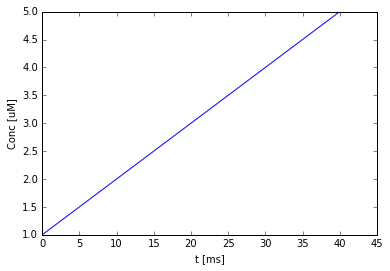

In [4]:
plt.plot(ts,concs)
plt.ylabel("Conc [uM]")
plt.xlabel("t [ms]")